# 프로젝트 목표
서울시 공공데이터로 서울시 내 동별 독거노인 수를 예측할 수 있는 모형을 설계

# 개요

고령화 사회 문제 중 가장 심각한 노인의 고독사이다. 이 문제를 해결하기 위해 앞으로 독거노인이 어디에 주거하게 될 것인지 예측이 필요하다고 생각했다. 그래서 먼저 데이터가 잘 갖추어진 서울시 내의 독거노인을 예측해보고자 했고 서울시 공공데이터를 활용해 간접적으로 독거노인의 주거를 예측하고자 했다.


### DATA SET (2012년 , 서울시 동별 자료)
- 출처 : 서울 열린데이터 광장 (http://data.seoul.go.kr/)
- Y(target)  : 독거노인 수
- X(feature) : 장애인, 화재 발생 건수, 은행 지점, 노인 복지시설, 전입인구, 전출인구
- Samples : 422

In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
from pandas.io.pytables import IndexCol
from pandas.core.frame import DataFrame
from requests.api import head
from sklearn import svm
from numpy import newaxis
from pip.req.req_file import preprocess
from mistune import preprocessing
from sklearn.linear_model.base import LinearRegression
sns.set()
# sns.set_palette('pastel')

In [2]:
data = pd.read_csv('raw_data_number.csv', header=0, encoding='cp949')
print(data.tail())

        code   gu  dong  disable  fire  bank  seniorcenter  movingin  \
418  강동구둔촌1동  강동구  둔촌1동      455    10     2             8      2849   
419  강동구둔촌2동  강동구  둔촌2동     1003    13     7             5      4076   
420  강동구암사1동  강동구  암사1동     1617    15     4             3      6099   
421  강동구천호2동  강동구  천호2동     1847    29     7            13      5960   
422    강동구길동  강동구    길동     1950    37     9            15      7373   

     movingout  older  older2013  
418       3050    665        727  
419       4385    453        502  
420       6374    821        880  
421       6265    186        199  
422       7939    508        547  


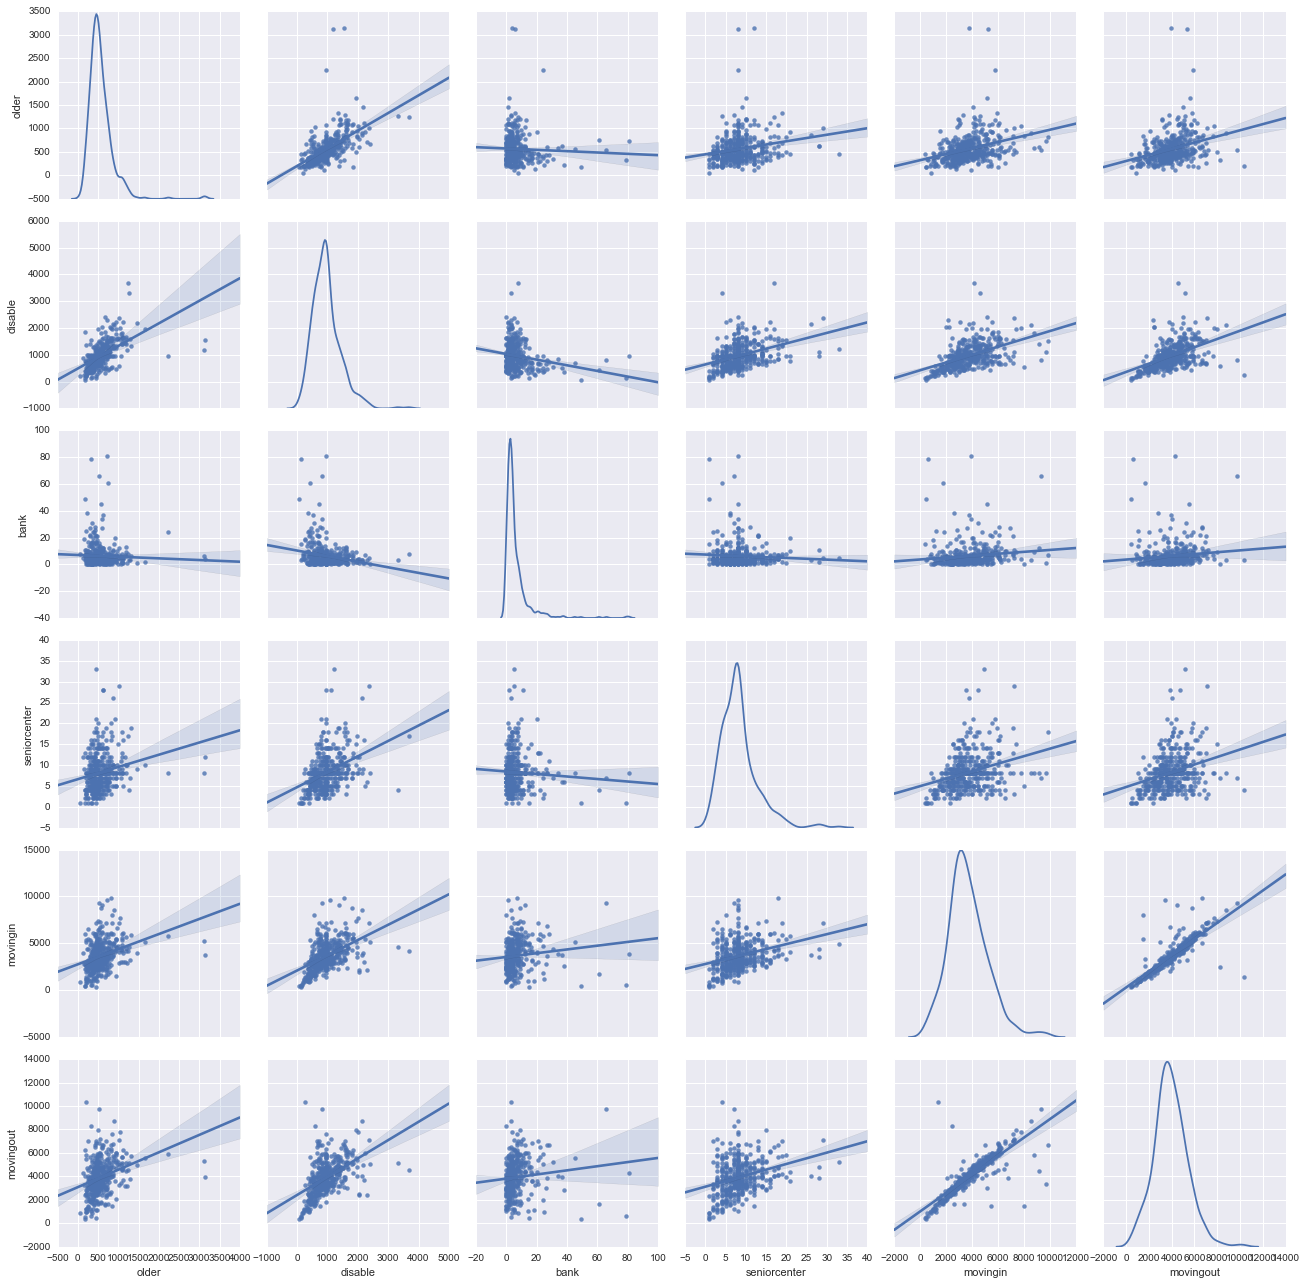

In [3]:
# 눈으로 자료의 관계성 확인
sns.pairplot(data, diag_kind="kde", kind="reg" ,vars = ['older', 'disable', 'bank', 'seniorcenter', 'movingin', 'movingout'], size=3)
plt.show()

# X, Y data

In [4]:
y = data['older']
y2 = data['older2013']
x = data.drop(labels = ['code', 'gu', 'dong', 'older', 'older2013'], axis=1)

               disable      fire      bank  seniorcenter  movingin  movingout  \
disable       1.000000  0.185589 -0.209666      0.380607  0.488196   0.489488   
fire          0.185589  1.000000  0.489940      0.075529  0.411065   0.429240   
bank         -0.209666  0.489940  1.000000     -0.061527  0.119592   0.109945   
seniorcenter  0.380607  0.075529 -0.061527      1.000000  0.308768   0.295052   
movingin      0.488196  0.411065  0.119592      0.308768  1.000000   0.824094   
movingout     0.489488  0.429240  0.109945      0.295052  0.824094   1.000000   
older         0.562763  0.251880 -0.042128      0.201830  0.323813   0.311607   
older2013     0.748737  0.287850 -0.075903      0.293232  0.405319   0.414577   

                 older  older2013  
disable       0.562763   0.748737  
fire          0.251880   0.287850  
bank         -0.042128  -0.075903  
seniorcenter  0.201830   0.293232  
movingin      0.323813   0.405319  
movingout     0.311607   0.414577  
older         1.00

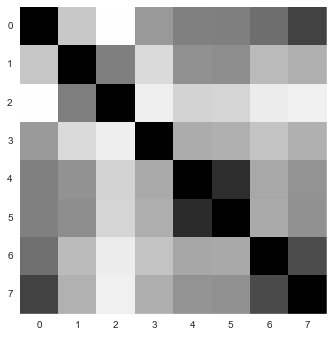

In [5]:
# correlation 확인
print(data.corr())
plt.imshow(data.corr(), interpolation="none")
plt.grid(False)
plt.show()

In [6]:
from sklearn.preprocessing import scale
# from sklearn.preprocessing import normalize => Unit Vector 로 만드는 함수다! Normalize 가 아니다
# Normalize 할 수 없는 것은 안해도 데이터 분석에는 minor 한 문제이다.

x_scale = pd.DataFrame(scale(x), index = x.index, columns = x.columns)
# x_scale_norm = pd.DataFrame(normalize(x_scale), columns = x.columns)

In [7]:
x_scale.tail()

,disable,fire,bank,seniorcenter,movingin,movingout
418,-1.102795,-0.422835,-0.468895,-0.059009,-0.538236,-0.591978
419,0.082741,-0.063680,0.075703,-0.727607,0.259572,0.314510
420,1.411059,0.175757,-0.251056,-1.173339,1.574948,1.665075
421,1.908638,1.851815,0.075703,1.055320,1.484569,1.591062
422,2.131467,2.809563,0.293542,1.501052,2.403316,2.727737


      disable      fire      bank  seniorcenter  movingin  movingout  older
418 -1.102795 -0.422835 -0.468895     -0.059009 -0.538236  -0.591978    665
419  0.082741 -0.063680  0.075703     -0.727607  0.259572   0.314510    453
420  1.411059  0.175757 -0.251056     -1.173339  1.574948   1.665075    821
421  1.908638  1.851815  0.075703      1.055320  1.484569   1.591062    186
422  2.131467  2.809563  0.293542      1.501052  2.403316   2.727737    508


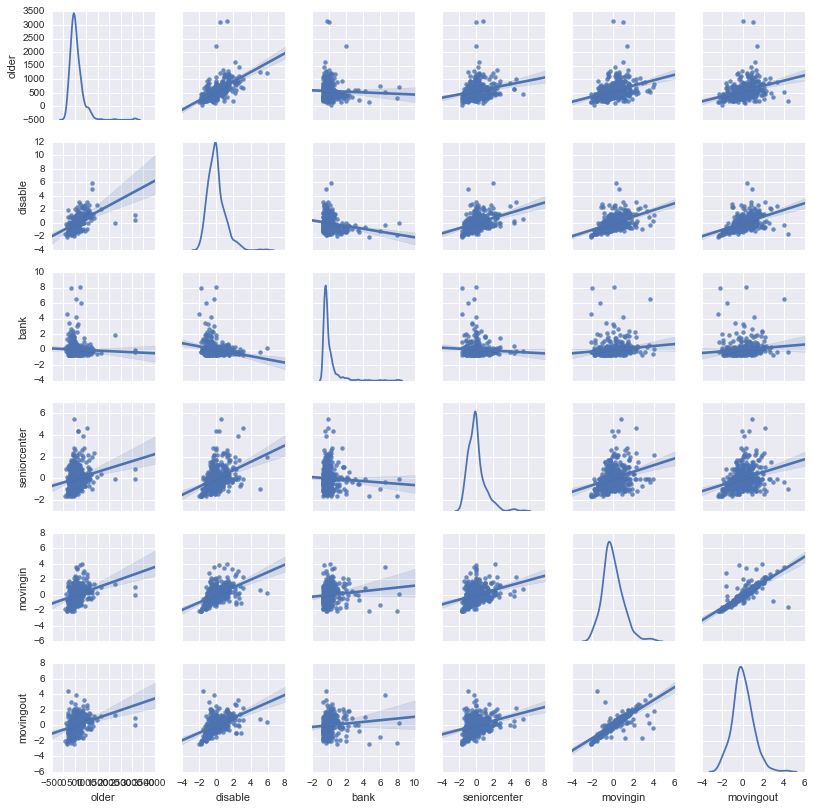

In [8]:
#scaling 된 것의 pairplot을 위해 잠시 y를 붙인 x_test를 만듦
x_test = pd.concat([x_scale, y], axis=1)
print(x_test.tail())
sns.pairplot(x_test, diag_kind="kde", kind="reg"
             ,vars = ['older', 'disable', 'bank', 'seniorcenter', 'movingin', 'movingout'], size=1.9)
plt.show()

In [9]:
import statsmodels.api as sm

In [10]:
model_OLS = sm.OLS(y,x_scale) 
result_OLS = model_OLS.fit()
print(result_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  older   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     5.930
Date:                Sat, 26 Mar 2016   Prob (F-statistic):           5.88e-06
Time:                        13:01:46   Log-Likelihood:                -3318.2
No. Observations:                 423   AIC:                             6648.
Df Residuals:                     417   BIC:                             6673.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
disable        167.5567     38.692      4.331   

In [11]:
# Intercept 추가

x_intercept = sm.add_constant(x_scale)
print(x_intercept.head())

model_OLS = sm.OLS(y,x_intercept) 
result_OLS = model_OLS.fit()
print(result_OLS.summary())

   const   disable      fire      bank  seniorcenter  movingin  movingout
0      1 -1.312643  0.295475  1.927336     -1.396205 -1.213154  -1.319205
1      1 -1.797242 -0.662272 -0.359975     -1.396205 -2.096790  -2.290879
2      1 -1.293173 -0.303117 -0.468895     -0.950473 -1.276225  -1.422416
3      1 -0.765307  1.013786 -0.142136     -0.727607 -0.742402  -0.839819
4      1 -1.381872 -1.141146 -0.577814     -0.950473 -1.606531  -1.811493
                            OLS Regression Results                            
Dep. Variable:                  older   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     35.76
Date:                Sat, 26 Mar 2016   Prob (F-statistic):           6.99e-35
Time:                        13:01:46   Log-Likelihood:                -2937.6
No. Observations:                 423   AIC:                             5889.
Df 

# OLS 모형 1차 해석
- Adj. R-squared 값이 0.331로 낮다
- F값의 p-value 값을 볼 때, 6.99e-35로 0에 가까우므로 모든 회귀계수가 0이라는 귀무가설을 기각하여 모형은 제대로 형성
- 독립변수들 하나하나를 살펴 볼 때 'bank', 'seniorcenter', 'movingin', 'movingout' 들은 T값의 p-value가 유의수준 0.01보다 커서 각 회귀계수가 0이라는 귀무가설을 기각하지 못한다. 의미는 회귀계수가 0이라서 그 값이 의미가 없음

- Omnibus의 P-value 값과 Jarque-Bera (JB)의 p-value 값을 살펴 볼 때 유의 수준 0.05보다 크므로 정규분포라는 귀무가설을 기각하지 못함으로 이 데이터들은 정규분포의 가정을 만족\

# OLS 모형 개선

In [12]:
# P>|t| >0.01인 feature 제거
x_intercept = x_intercept.drop(labels = ['bank', 'movingout', 'seniorcenter', 'movingin'], axis=1)

In [13]:
model_OLS = sm.OLS(y,x_intercept) 
result_OLS = model_OLS.fit()
print(result_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  older   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     107.8
Date:                Sat, 26 Mar 2016   Prob (F-statistic):           1.63e-38
Time:                        13:01:46   Log-Likelihood:                -2938.0
No. Observations:                 423   AIC:                             5882.
Df Residuals:                     420   BIC:                             5894.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        563.9504     12.261     45.994      0.0

# Outlier detection and removal

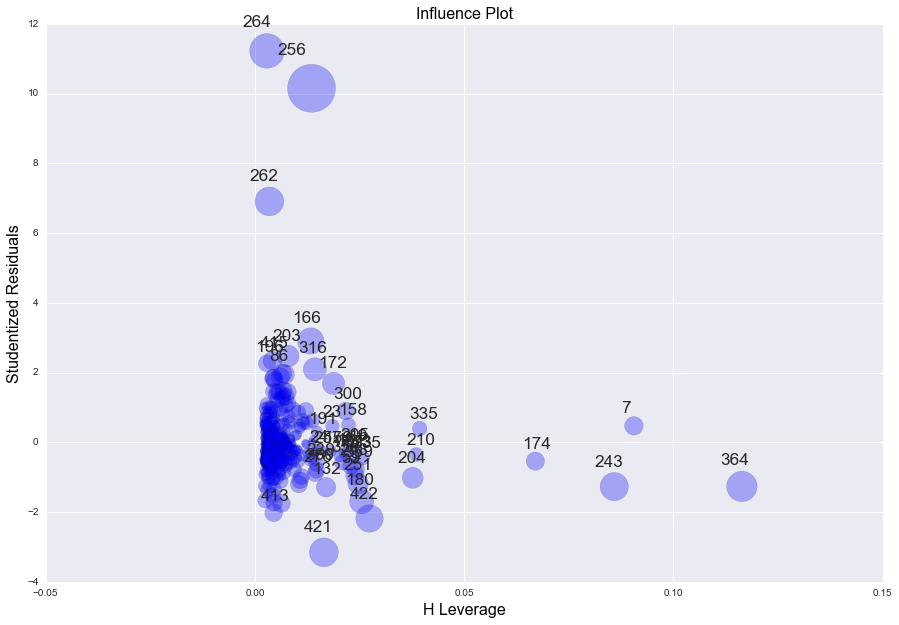

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
sm.graphics.influence_plot(result_OLS, plot_alpha=0.3, ax=ax)
plt.show()

(Outlier 제거는 feature selecting 이전에 해주어도 된다)

In [15]:
# Influence 가 10% 미만인 값은 Outlier
idx_outlier = np.nonzero(result_OLS.outlier_test().ix[:, -1].abs() < 0.01)[0]
idx_outlier

array([256, 262, 264])

In [16]:
print(data.ix[[264, 262, 256]])

        code   gu  dong  disable  fire  bank  seniorcenter  movingin  \
264  구로구구로5동  구로구  구로5동     1169    13     6             8      5218   
262  구로구구로3동  구로구  구로3동      944    19    24             8      5758   
256  강서구방화2동  강서구  방화2동     1548    30     4            12      3745   

     movingout  older  older2013  
264       5304   3115        870  
262       5872   2237        596  
256       3946   3146        954  


# Insight #1
- 아웃라이어(구로5동, 구로3동, 방화2동) 상위업종 10개를 조사해본 결과 택시업 종사자 비율이 높다

- 서울시의 428개 동중 방화2동, 구로3동이 각각 2,3위 이다

- 따라서, 독거노인과 택시업 연관관계가 있다고 추측된다

# Insight #2
- 노인복지센터는 현재 수요-공급 불균형이다


 # After outlier removal

In [17]:
#Outlier removal
x_intercept_out = x_intercept.drop(idx_outlier)
y_out = y.drop(idx_outlier)

In [18]:
model_OLS_out = sm.OLS(y_out, x_intercept_out)
result_OLS_out = model_OLS_out.fit()
print(result_OLS_out.summary())

                            OLS Regression Results                            
Dep. Variable:                  older   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     199.3
Date:                Sat, 26 Mar 2016   Prob (F-statistic):           1.77e-61
Time:                        13:01:47   Log-Likelihood:                -2758.2
No. Observations:                 420   AIC:                             5522.
Df Residuals:                     417   BIC:                             5535.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        548.5857      8.429     65.084      0.0

# OLS 모형 2차 해석
무의미한 피처 제거와 아웃라이어에 해당하는 3개 샘플을 제거하여 모형을 개선할 수 있었다

# 모형 검증

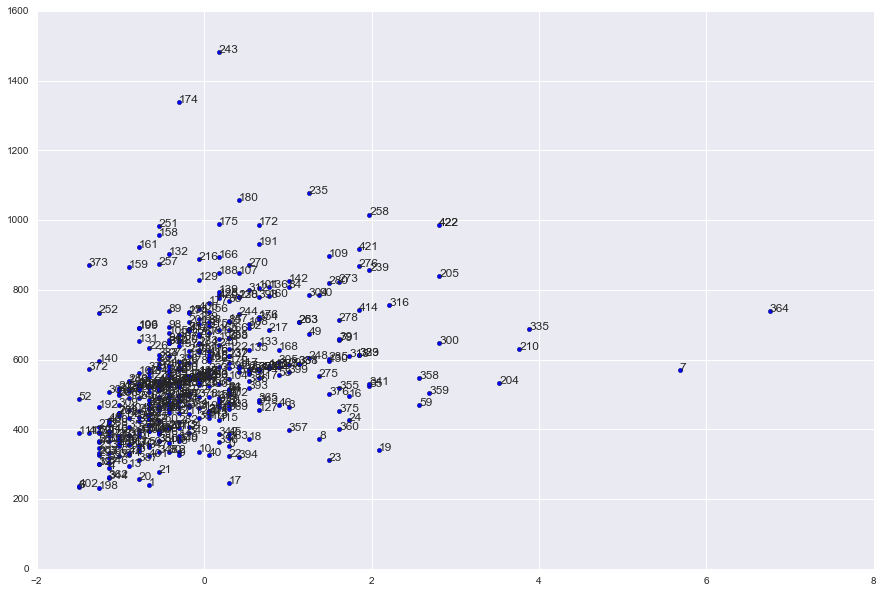

In [19]:
# 데이터 눈으로 확인하기
fig, ax = plt.subplots(figsize=(15, 10))

# http://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point
for i, txt in x_intercept_out.iterrows():
    ax.annotate(txt.name, (x_intercept_out['fire'][i],result_OLS_out.fittedvalues[i]))

plt.scatter(x_intercept_out['fire'], result_OLS_out.fittedvalues)
ax.annotate(txt.name, (x_intercept_out['fire'][i],result_OLS_out.fittedvalues[i]))
plt.show()

### 위 그래프에서 볼 수 있듯 [fire] feature 샘플중 눈에 띄게 선형성을 보이는 샘플들이 있어 별도로 조사해 보았으나 특이점을 찾을 수 없음


# Closs-validation(K-Fold) 

In [20]:
# outlier를 3개 제거한 후 X,Y 그 크기가 같은지 확인

print(x_intercept_out.describe)
len(y_out)

<bound method NDFrame.describe of      const   disable      fire
0        1 -1.312643  0.295475
1        1 -1.797242 -0.662272
2        1 -1.293173 -0.303117
3        1 -0.765307  1.013786
4        1 -1.381872 -1.141146
5        1 -1.165533 -0.781991
6        1 -1.645805 -1.500302
7        1 -1.143899  5.682807
8        1 -1.416486  1.372942
9        1 -1.338604 -0.303117
10       1 -1.329950 -0.063680
11       1 -0.815065 -0.422835
12       1 -1.295336 -1.260865
13       1 -1.407832 -0.901709
14       1 -0.988135 -0.303117
15       1 -0.724202 -0.662272
16       1 -0.722039  1.732097
17       1 -1.985456  0.295475
18       1 -1.241252  0.534912
19       1 -1.779935  2.091252
20       1 -1.663112 -0.781991
21       1 -1.593883 -0.542554
22       1 -1.498694  0.295475
23       1 -1.831856  1.492660
24       1 -1.163370  1.732097
25       1 -0.501374 -0.422835
26       1 -0.021102 -0.542554
27       1 -0.607379 -1.260865
28       1 -0.981645 -1.021428
29       1 -1.117939 -1.260865
..   

420

In [21]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold


# Outlier 빼야한다
# cross_val_score (model 의 하이퍼 파라메터를 넣어줘야한다)


print("r2_score : " , cross_val_score(LinearRegression(), x, y, "r2", KFold(len(x_intercept_out),4)))
print("mean_squared_error : " , cross_val_score(LinearRegression(), x, y, "mean_squared_error", KFold(len(x_intercept_out),4)))

r2_score :  [ 0.55668821  0.40583812  0.17416245  0.03749283]
mean_squared_error :  [ -20953.67106286  -43302.46750175 -153705.70093344  -43095.19309754]


/Users/DS/.pyenv/versions/3.5.0/envs/my-virtual-env-3.5.0/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


# K-SVR(Kernel Support Vector Regression)

In [22]:
# SVR(Support Vector Regression), Radial Basis Function (RBF) kernel SVM #########################
print("\n ##Support Vector Regression Score##")
from sklearn.svm import SVR
svr_linear = SVR(kernel='linear')
svr_poly = SVR(kernel='poly')
svr_sigmoid = SVR(kernel='sigmoid')
svr_rbf = SVR(kernel='rbf')

score_l = svr_linear.fit(x_intercept_out, y_out).score(x_intercept_out ,y_out)
print("SVR_linear model(score)  : ", score_l)


 ##Support Vector Regression Score##
SVR_linear model(score)  :  0.432845548706


In [23]:
score_s = svr_sigmoid.fit(x_intercept_out, y_out).score(x_intercept_out ,y_out)
score_r = svr_rbf.fit(x_intercept_out, y_out).score(x_intercept_out ,y_out)
score_p = svr_poly.fit(x_intercept_out, y_out).score(x_intercept_out ,y_out)

print("SVR_poly model(score)    : ", score_p)
print("SVR_sigmoid model(score) : ", score_s)
print("SVR_rbf model(score)     : ", score_r)

SVR_poly model(score)    :  0.201752755163
SVR_sigmoid model(score) :  -0.0385204174347
SVR_rbf model(score)     :  0.140741554671


# TEST

###  2013년 화재 발생 수, 장애인 수 데이터가 없으므로 2012년 독거노인 수와 2013년 독거노인 수가 선형일치하면 2012년 데이터로 만든 모델로 예측한 값을 2013년 실제 값과 비교하는 것으로 TEST

In [24]:
#2013년도 독거 노인 수 - 아웃라이어(구로5동, 구로3동, 방화2동) 제외
y2_out = y2.drop(idx_outlier)

In [25]:
# sns.jointplot("older", "older2013", data=data, kind="reg", color="r", size=8)
# plt.show()

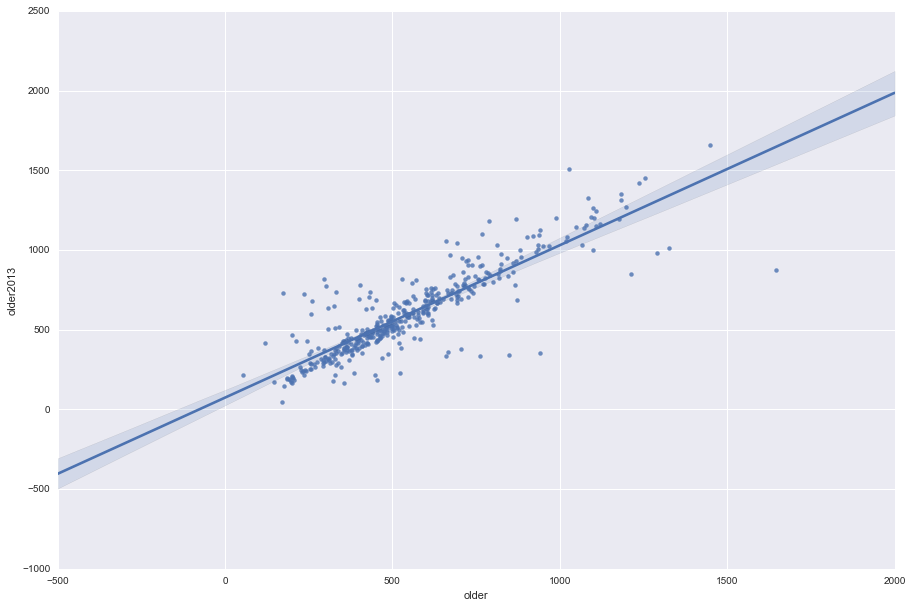

In [26]:
data_out = data.drop(idx_outlier)
fig, ax = plt.subplots(figsize=(15, 10))
sns.regplot("older", "older2013", data=data_out)
# Size of the confidence interval used when plotting a central tendency for discrete values of x. If “ci”, defer to the value of the``ci`` parameter.
plt.show()

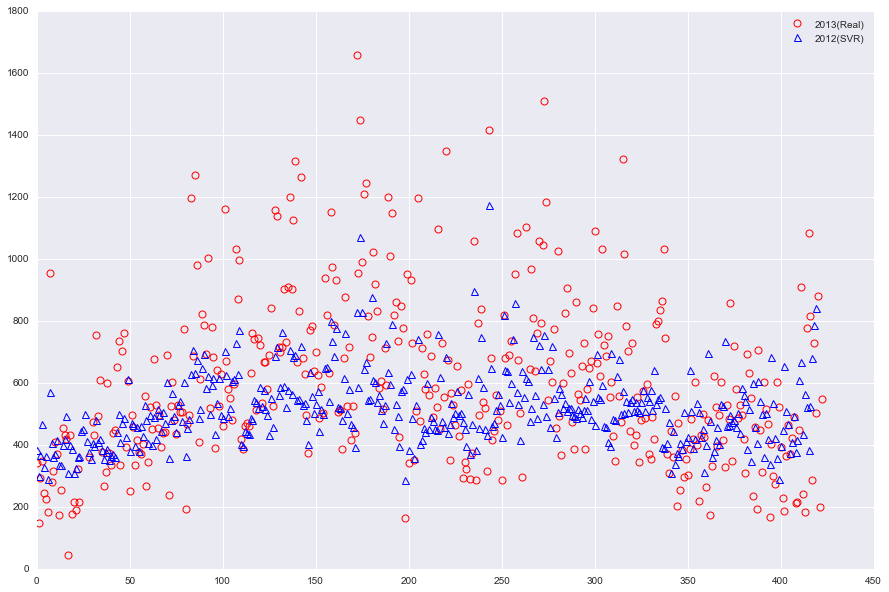

In [27]:
predictions_OLS = result_OLS_out.predict()
predictions_SVR = svr_linear.fit(x_intercept_out, y_out).predict(x_intercept_out)

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(y2_out, 'o', markersize=7, markeredgewidth=1
         , markeredgecolor='r', markerfacecolor='None', label="2013(Real)")
plt.plot(predictions_SVR, 'r^', markersize=7, markeredgewidth=1
         , markeredgecolor='b', markerfacecolor='None', label="2012(SVR)")
plt.legend()
plt.show()

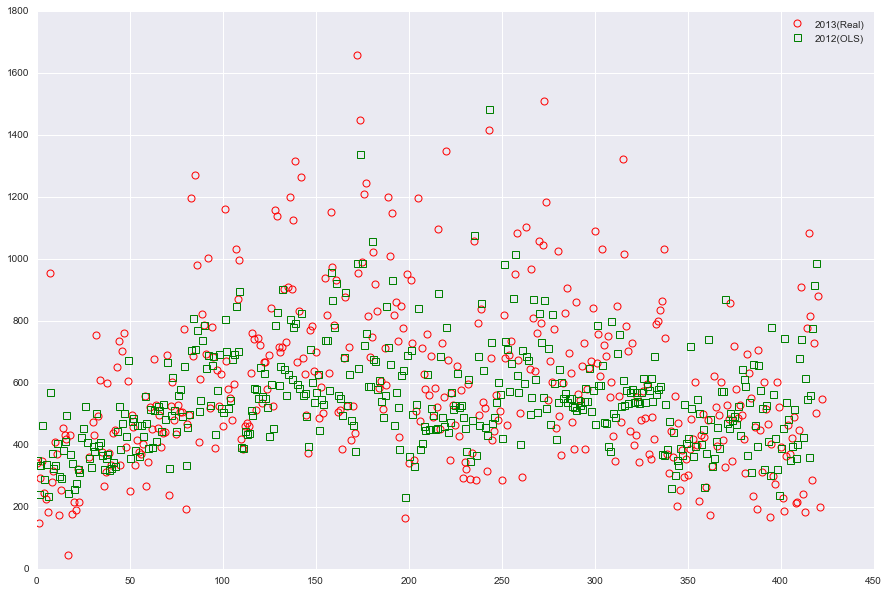

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(y2_out, 'o', markersize=7, markeredgewidth=1
         , markeredgecolor='r', markerfacecolor='None', label="2013(Real)")
plt.plot(predictions_OLS, 's', markersize=7, markeredgewidth=1
         , markeredgecolor='g', markerfacecolor='None', label="2012(OLS)")

plt.legend()
plt.show()

# 최종 결론
- OLS모형이 Kernel SVR(kernel = linear)의 모형보다 모형 성능은 약간 높다
- 독거노인 수와 장애인 수, 화재 발생건수 들은 선형관계가 있다
- 독거노인 수와 은행 수, 노인복지 시설 수, 전입 인구 수, 전출 인구 수는 선형관계에 있지않다


# Review
- Model selection 을 수행하면 어떤 모형이 추천될것인가?
- Regularization 을 수행하면 어떤 변화가 예상되는가?